In [1]:
import pandas as pd
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, confusion_matrix,accuracy_score, roc_curve, auc, precision_recall_curve

from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 5,2

### Utility

In [2]:
def plot_attention(x, y, figname):
    if len(y) == 0: return
    
#     p0 = len(x)
#     for i in range(y.shape[0]):
#         if y[i] == y[i+1] and y[i+1] == y[i+2]:
#             p0 = i+2
#             break

#     x = x[:p0]
#     y = y[:p0]
#     print(x.shape, y.shape)
    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
    ax.set_yticks([])
    ax.set_xlim(extent[0], extent[1])
    ax.set_xlabel("Time (by 4 hours)")
#     ax2.set_xlabel("Feature (index)")
    ax.set_ylabel("Weight")
    
    ax2.plot(x,y)
    ax2.set_xlabel("Time (by 4 hours)")
#     ax2.set_xlabel("Feature (index)")
    ax2.set_ylabel("Weight")
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    
def plot_featuremap(x, y, figname):
    if len(y) == 0: return
    
#     p0 = len(x)
#     for i in range(y.shape[0]):
#         if y[i] == y[i+1] and y[i+1] == y[i+2]:
#             p0 = i+2
#             break

#     x = x[:p0]
#     y = y[:p0]
#     print(x.shape, y.shape)
    fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)

    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
    ax.set_yticks([])
    ax.set_xlim(extent[0], extent[1])
#     ax.set_xlabel("Time (by 4 hours)")
    ax2.set_xlabel("Feature (index)")
    ax.set_ylabel("Weight")
    
    ax2.plot(x,y)
#     ax2.set_xlabel("Time (by 4 hours)")
    ax2.set_xlabel("Feature (index)")
    ax2.set_ylabel("Weight")
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()
    
    # print top 10 features
    top10=np.argsort(y)[-10:][::-1]
    
    print('top10 features are', top10)

In [3]:
import pickle
with open('MS_train.pt', 'rb') as f:
    train_data = pickle.load(f)
with open('MS_test.pt', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
type(train_data[0]) ,len(train_data), len(test_data)

(tuple, 167, 132)

In [5]:
test_data[0][1][0].shape, test_data[0][1][1].shape, test_data[0][1][2].shape, test_data[0][1][3].shape, test_data[0][1][4].shape, \
test_data[0][1][5].shape, test_data[0][1][6].shape, test_data[0][1][7].shape, test_data[0][1][8].shape, test_data[0][1][9].shape

(torch.Size([3, 80]),
 torch.Size([6, 12]),
 torch.Size([1, 12]),
 torch.Size([256]),
 torch.Size([258]),
 torch.Size([258]),
 torch.Size([258]),
 torch.Size([258]),
 torch.Size([258]),
 torch.Size([21]))

In [6]:
from torch.utils.data import Dataset
class Covid_19(Dataset):
    def __init__(self,dataList):
        self.data_list = dataList
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
#         print("idx",idx)
        ptid = self.data_list[idx][0]
        sample = self.data_list[idx][1]
        return sample
    

In [7]:
import torch
import torch.utils.data
import torchvision


class Sampler(torch.utils.data.sampler.Sampler):

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):

        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        self.callback_get_label = callback_get_label

        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset[idx][-1]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [8]:
import torch.nn.functional as F

def pad_collate(batch):
    (pt_lab_batch, pt_vital_batch, pt_med_batch, 
     notes_embed_i, 
     T1_pre_embed_i, T1_post_embed_i, T2_embed_i, flair_embed_i, pd_embed_i,
     pt_demo_batch, 
     label_batch) = zip(*batch)
    
    pt_notes_embed_batch =torch.stack([item[3] for item in batch])
    pt_T1_pre_embed_batch =torch.stack([item[4] for item in batch])
    pt_T1_post_embed_batch =torch.stack([item[5] for item in batch])
    pt_T2_embed_batch =torch.stack([item[6] for item in batch])
    pt_flair_embed_batch =torch.stack([item[7] for item in batch])
    pt_pd_embed_batch =torch.stack([item[8] for item in batch])
    pt_demo_batch =torch.stack([item[9] for item in batch])
    label_batch =[item[10] for item in batch]

    max_lab = np.max(np.array([[DB.size(0),DB.size(1)]for DB in pt_lab_batch]),axis=0)
    max_vital = np.max(np.array([[DB.size(0),DB.size(1)]for DB in pt_vital_batch]),axis=0)
    max_med= np.max(np.array([[DB.size(0),DB.size(1)]for DB in pt_med_batch]),axis=0)

    lab_batch = torch.stack([
        F.pad(DB, [0, max_lab[1] - DB.size(1), 0, max_lab[0] - DB.size(0)])
        for DB in pt_lab_batch
        ])
    vital_batch = torch.stack([
        F.pad(DB, [0, max_vital[1] - DB.size(1), 0, max_vital[0] - DB.size(0)])
        for DB in pt_vital_batch
        ])
    med_batch = torch.stack([
        F.pad(DB, [0, max_med[1] - DB.size(1), 0, max_med[0] - DB.size(0)])
        for DB in pt_med_batch
        ])


    return lab_batch, vital_batch, med_batch, pt_notes_embed_batch, \
            pt_T1_pre_embed_batch, pt_T1_post_embed_batch, pt_T2_embed_batch, pt_flair_embed_batch, pt_pd_embed_batch, \
            pt_demo_batch, label_batch

In [9]:
import torch
import torch.utils.data
import torchvision


class Sampler(torch.utils.data.sampler.Sampler):

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):

        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        self.callback_get_label = callback_get_label

        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset[idx][-1]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [10]:
from torch.utils.data import DataLoader

train_dataset=Covid_19(train_data)
validation_dataset = Covid_19(test_data)
trainSampler = Sampler(train_dataset)
dataloader = DataLoader(train_dataset, batch_size=24,
                        shuffle=False, num_workers=0,drop_last=True,collate_fn=pad_collate,sampler = trainSampler)
validation_loader = DataLoader(validation_dataset, batch_size=24,
                        shuffle=False, num_workers=0,drop_last=True,collate_fn=pad_collate)

In [15]:
class DBNet(nn.Module):
    def __init__(self):

        super(DBNet, self).__init__()
        
        ####vars to set
        dropout_GRU = 0.5
        hidden_size=512
        no_GRU_layers=4
        output_size = 2
        GRU_input_size = 256#258 
        no_hops = 8
        
        
        ###(kernel_size,in_channel,out_channel, stride,pad)  
        lab_kernels = [(7,1,8,2,0),(4,8,8,2,0),(3,8,1,2,1)]
        vital_kernels =  [(3,1,8,2,0),(2,8,1,2,1)]
        medAdmin_kernels = [(3,1,8,2,0),(2,8,1,2,1)]

        self.lab_layers = nn.ModuleList()
        self.vital_layers = nn.ModuleList()
        self.medAdmin_layers = nn.ModuleList()

        self.make_encoder_block(lab_kernels,self.lab_layers)
        self.make_encoder_block(vital_kernels,self.vital_layers)
        self.make_encoder_block(medAdmin_kernels,self.medAdmin_layers)

        self.GRU = nn.GRU(GRU_input_size, hidden_size, no_GRU_layers, dropout=dropout_GRU,
                                         batch_first=True, bias=False, bidirectional=True)
        self.GRU_dropout = nn.Dropout(p=dropout_GRU)
        self.conv_att = nn.Conv1d(in_channels=1, out_channels=no_hops, kernel_size=hidden_size * 2, stride=1)

        self.linear = nn.Linear(hidden_size * 2 * no_hops + 21, output_size, bias=False)


        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Hardtanh(0, 1)
        self.init_weights()
        self.no_hops = no_hops
        self.hidden_size = hidden_size 
        self.output_size = output_size
        self.no_GRU_layers = no_GRU_layers

        
    def make_encoder_block(self,kernel_list,layer_list):
        for i,kernels in enumerate(kernel_list):
            layer_list.append(nn.Conv1d(in_channels=kernels[1],
                                        out_channels=kernels[2],
                                        kernel_size=kernels[0],
                                        stride=kernels[3],
                                        padding=kernels[4]))
            if i <len(layer_list)-1:
                layer_list.append(nn.ReLU())
            layer_list.append(nn.Dropout(p=0.3))
        layer_list.append(nn.AdaptiveAvgPool1d(1))

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Conv1d):
                torch.nn.init.xavier_uniform_(m.weight)


    def lab_encoder(self, lab):
        encoded_DAMs=[]
        for i in range(lab.size(1)):
            for j,layer in enumerate(self.lab_layers):
                if j==0:
                    out = layer(torch.unsqueeze(lab[:,i],dim=1))
                else:
                    out =layer(out)
            encoded_DAMs.append(out)
        # ------------ plot attention weights
#         print('Attension weights is encoded_DAMs is', len(encoded_DAMs))
#         x = np.array(range(len(encoded_DAMs)), dtype=int)
#         y = np.array([[i[0][0][0].item() for i in encoded_DAMs]]).squeeze()
#         plot_attention(x, y, 'time-lab.pdf')
        # -----------------------------------
        encoded_DAMs = torch.stack(encoded_DAMs)
        encoded_DAMs = torch.squeeze(encoded_DAMs, dim=3)
        encoded_DAMs = torch.transpose(encoded_DAMs, 0, 1)
        encoded_DAMs = torch.transpose(encoded_DAMs, 1, 2)
        encoded_DAMs = self.tanh(encoded_DAMs)
        encoded_DAMs = torch.bmm(encoded_DAMs, lab)
        encoded_DAMs = torch.squeeze(encoded_DAMs, dim=1)
        # ------------ plot feature weights
#         print('Feature weights is encoded_DAMs is', len(encoded_DAMs), encoded_DAMs.shape)
#         x = np.array(range(encoded_DAMs.shape[1]), dtype=int)
#         y = encoded_DAMs[0,:].cpu().detach().numpy()
#         plot_featuremap(x, y, 'feature_lab.pdf')
        # -----------------------------------
        return encoded_DAMs
    
    def vital_encoder(self, vital):
        encoded_DPCs=[]
        for i in range(vital.size(1)):
            for j,layer in enumerate(self.vital_layers):
                if j==0:
                    out = layer(torch.unsqueeze(vital[:,i],dim=1))
                else:
                    out =layer(out)
            encoded_DPCs.append(out)
        # ------------ plot attention weights
#         print('Attension weights is encoded_DPCs is', len(encoded_DPCs))
#         x = np.array(range(len(encoded_DPCs)), dtype=int)
#         y = np.array([[i[0][0][0].item() for i in encoded_DPCs]]).squeeze()
#         plot_attention(x, y, 'time-diag.pdf')
        # -----------------------------------    
        encoded_DPCs = torch.stack(encoded_DPCs)
        encoded_DPCs = torch.squeeze(encoded_DPCs, dim=3)
        encoded_DPCs =  torch.transpose(encoded_DPCs, 0, 1)
        encoded_DPCs = torch.transpose(encoded_DPCs, 1, 2)
        encoded_DPCs = self.tanh(encoded_DPCs)
        encoded_DPCs = torch.bmm(encoded_DPCs, vital)
        encoded_DPCs = torch.squeeze(encoded_DPCs, dim=1)
        # ------------ plot feature weights
#         print('Feature weights is encoded_DPCs is', len(encoded_DPCs), encoded_DPCs.shape)
#         x = np.array(range(encoded_DPCs.shape[1]), dtype=int)
#         y = encoded_DPCs[0,:].cpu().detach().numpy()
#         plot_featuremap(x, y, 'feature-diag.pdf')
        # -----------------------------------
        return encoded_DPCs
    
    def medAdmin_encoder(self, medAdmin):
        encoded_medAdmins = []
        for i in range(medAdmin.size(1)):
            for j,layer in enumerate(self.medAdmin_layers):
                if j==0:
                    out = layer(torch.unsqueeze(medAdmin[:,i],dim=1))
                else:
                    out =layer(out)
            encoded_medAdmins.append(out)
        # ------------ plot attention weights
#         print('Attension weights is encoded_medAdmins is', len(encoded_medAdmins))
#         x = np.array(range(len(encoded_medAdmins)), dtype=int)
#         y = np.array([[i[0][0][0].item() for i in encoded_medAdmins]]).squeeze()
#         plot_attention(x, y,'time-medAdmin.pdf')
        # ----------------------------------- 
        encoded_medAdmins = torch.stack(encoded_medAdmins)
        encoded_medAdmins = torch.squeeze(encoded_medAdmins, dim=3)
        encoded_medAdmins =  torch.transpose(encoded_medAdmins, 0, 1)
        encoded_medAdmins = torch.transpose(encoded_medAdmins, 1, 2)
        encoded_medAdmins = self.tanh(encoded_medAdmins)
        encoded_medAdmins = torch.bmm(encoded_medAdmins, medAdmin)
        encoded_medAdmins = torch.squeeze(encoded_medAdmins, dim=1)
        # ------------ plot feature weights
#         print('Feature weights is encoded_medAdmins is', len(encoded_medAdmins), encoded_medAdmins.shape)
#         x = np.array(range(encoded_medAdmins.shape[1]), dtype=int)
#         y = encoded_medAdmins[0,:].cpu().detach().numpy()
#         plot_featuremap(x, y, 'feature-medAdmins.pdf')
        # -----------------------------------
        return encoded_medAdmins
    
    
    def init_GRU(self, batch_size):
        self.weight = next(self.parameters()).data
        init_state = (Variable(self.weight.new(self.no_GRU_layers * 2, batch_size, self.hidden_size).zero_()))
        return init_state

    
    def GRU_Decoder(self, inputs,batch_size):
        inputs = self.GRU_dropout(inputs)
        init_state = self.init_GRU(batch_size)
        outputs, states = self.GRU(inputs, init_state)
        return outputs,states
    

    def Self_Attention(self, hidden_states, batch_size):
        Attention_list = []
        for i in range(4):
            m1 = self.conv_att(torch.unsqueeze(hidden_states[:, i], dim=1))
            Attention_list.append(torch.squeeze(m1, dim=2))
        Attention_list = torch.stack(Attention_list, dim=2)
        Attention_hops = []
        for i in range(self.no_hops):
            attention_single = self.softmax(Attention_list[:, i])
            Attention_hops.append(attention_single)
        Attention_hops = torch.stack(Attention_hops, dim=1)
        output = torch.bmm(Attention_hops, hidden_states)
        output = output.view(batch_size, -1)
        return output

    def forward(self, lab, vital, med, note_embed, MRI_embed_1, MRI_embed_2,MRI_embed_3,MRI_embed_4,MRI_embed_5, pt_demo, batch_size):
        encoded_labs = self.lab_encoder(lab)
        encoded_vital = self.vital_encoder(vital)
        encoded_medAdmins = self.medAdmin_encoder(med)
#         print(encoded_labs.shape)#  torch.Size([24, 300])
#         print(encoded_vital.shape)#  torch.Size([24, 300])
#         print(encoded_medAdmins.shape)#  torch.Size([24, 300])
#         print(MRI_embed.shape)
#         input()
#         print(encoded_problems)
        GRU_input=pad_sequence([torch.transpose(encoded_labs, 0, 1),
                                torch.transpose(encoded_vital, 0, 1),
                                torch.transpose(encoded_medAdmins, 0, 1), 
                                torch.transpose(note_embed, 0, 1), 
#                                 torch.transpose(MRI_embed_1, 0, 1), 
#                                 torch.transpose(MRI_embed_2, 0, 1), 
#                                 torch.transpose(MRI_embed_3, 0, 1), 
#                                 torch.transpose(MRI_embed_4, 0, 1), 
#                                 torch.transpose(MRI_embed_5, 0, 1), 
                               ])
#         print(GRU_input.shape)# torch.Size([376, 5, 24])

        GRU_input = torch.transpose(GRU_input, 0, 2)
#         print(GRU_input.shape) # torch.Size([24, 5, 376])
#         input("Stop here.")
        outputs_GRU,states_GRU = self.GRU_Decoder(GRU_input, batch_size)
        GRU_out = self.Self_Attention(outputs_GRU, batch_size)
        context = torch.cat((GRU_out, pt_demo), 1)
        linear_y = self.linear(context)
        out = self.sigmoid(linear_y)
        return linear_y,out

In [16]:
def evaluate(y_test, preds):
    roc_auc_macro = roc_auc_score(y_test, preds, average='macro')
    roc_auc_micro = roc_auc_score(y_test, preds, average='micro')
#     f1_macro= f1_score(y_test, preds, average='binary')
#     f1_micro= f1_score(y_test, preds, average='micro')      
    lr_precision, lr_recall, thresholds = precision_recall_curve(y_test, preds)
#     auprc = auc(lr_recall, lr_precision)
    auprc = average_precision_score(y_test, preds)
    f1_binary_best, f1_macro_best, f1_micro_best, thr_best = float('-inf'),float('-inf'), float('-inf'), 0
    for thr in thresholds:
        f1_binary, f1_macro, f1_micro = evaluate2(y_test, preds, thr)
#         print(f1_macro, f1_micro, f1_macro_best, f1_micro_best)
        if f1_binary > f1_binary_best or f1_macro > f1_macro_best or f1_micro > f1_micro_best:
            f1_binary_best = f1_binary
            f1_macro_best = f1_macro
            f1_micro_best = f1_micro
            thr_best = thr
    print("AUC-Macro: {}, \n AUC-Micro: {}, \n AUPRC: {}, \n F1-Binary: {}, \n F1-Macro: {}, \n F1-Micro: {}".format(roc_auc_macro,roc_auc_micro, auprc, f1_binary_best, f1_macro_best, f1_micro_best)) # F1, F1))
       
def evaluate2(y_test, preds, thr):  
    f1_binary= f1_score(y_test, preds>thr, average='binary')# 'macro')
    f1_macro= f1_score(y_test, preds>thr, average='macro')
    f1_micro= f1_score(y_test, preds>thr, average='micro') 
    return f1_binary, f1_macro, f1_micro


### Train

In [19]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
import time
EPOCHS = 500
batch_size=24
model=DBNet()
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

print("Starting Training of {} model")
# with open('performance.txt', 'a+') as f:
#     f.write("Starting Training of {} model\n")
epoch_times = []
best_AUC=0
for epoch in range(1,EPOCHS+1):
    start_time = time.time()
    avg_loss = 0.
    counter = 0
    correct = 0
    total = 0
    model.train()
    for sample in dataloader:
        lab, vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,label = sample
        model.zero_grad()
        one_hot_label = np.eye(2)[np.array(label,dtype="int")]
        one_hot_label = torch.tensor(one_hot_label)
        label= torch.tensor(label).type(torch.long)
        lab = lab.to(device)
        vital = vital.to(device)
        medAdmin = medAdmin.to(device)
        note_embed = note_embed.to(device)
        MRI_embed_1 = MRI_embed_1.to(device)
        MRI_embed_2 = MRI_embed_2.to(device)
        MRI_embed_3 = MRI_embed_3.to(device)
        MRI_embed_4 = MRI_embed_4.to(device)
        MRI_embed_5 = MRI_embed_5.to(device)
        pt_demo = pt_demo.to(device)
        counter += 1
        out,predict=model(lab, vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,batch_size)
        one_hot_label = one_hot_label.type_as(out).to(device)
        loss = criterion(out, one_hot_label)
        _, predicted = torch.max(predict.detach().cpu(), 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    current_time = time.time()
    print("Epoch {}/{} Done, Total Loss: {}, Accuracy : {} ".format(epoch, EPOCHS, avg_loss/len(dataloader),correct/total))
    print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
#     with open('performance.txt', 'a+') as f:
#         f.write("Epoch {}/{} Done, Total Loss: {}, Accuracy : {} \n".format(epoch, EPOCHS, avg_loss/len(dataloader),correct/total))
#         f.write("Total Time Elapsed: {} seconds\n".format(str(current_time-start_time)))
    epoch_times.append(current_time-start_time)
    val_total=0
    val_correct = 0
    model.eval()
    predicted_list=[]
    prediction_probablity=[]
    label_list = []
    for sample in validation_loader:
        lab,vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,label = sample
        #model.zero_grad()
        label= torch.tensor(label).type(torch.long)
        lab = lab.to(device)
        vital = vital.to(device)
        medAdmin = medAdmin.to(device)
        note_embed = note_embed.to(device)
        MRI_embed_1 = MRI_embed_1.to(device)
        MRI_embed_2 = MRI_embed_2.to(device)
        MRI_embed_3 = MRI_embed_3.to(device)
        MRI_embed_4 = MRI_embed_4.to(device)
        MRI_embed_5 = MRI_embed_5.to(device)
        pt_demo = pt_demo.to(device)
        out,predict=model(lab,vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,batch_size)
        _, predicted = torch.max(predict.detach().cpu(), 1)
        predicted_list.append(predicted.cpu().numpy())
        predicted_2 = predict.detach().cpu().numpy()
        prediction_prob = predicted_2[:,1]
        prediction_probablity.append(prediction_prob)
        label_list.append(label.cpu().numpy())
        val_total += label.size(0)
        val_correct += (predicted == label).sum().item()
    Accuracy = val_correct/val_total
    y=np.array(label_list)
    false_positive_rate, recall, thresholds = roc_curve(y.flatten(), np.array(prediction_probablity).flatten())
    roc_auc = auc(false_positive_rate, recall)
    if roc_auc > best_AUC:
        best_AUC = roc_auc
        torch.save(model.state_dict(), "Models_saved_DBNet_EHR_notes/State_checkpoints_{}.thr".format(epoch))
        torch.save(model, "Models_saved_DBNet_EHR_notes/Model_checkpoints_{}.thr".format(epoch))
    print("AUC: {} , Accuracy: {}".format(roc_auc,Accuracy))
#     with open('performance.txt', 'a+') as f:
#         f.write("AUC: {} , Accuracy: {}\n".format(roc_auc,Accuracy))
print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
# with open('performance.txt', 'a+') as f:
#     f.write("Total Training Time: {} seconds\n".format(str(sum(epoch_times))))


Starting Training of {} model
Epoch 1/500 Done, Total Loss: 1.9249302744865417, Accuracy : 0.5694444444444444 
Total Time Elapsed: 0.6137964725494385 seconds
AUC: 0.6232638888888888 , Accuracy: 0.7666666666666667
Epoch 2/500 Done, Total Loss: 0.8742024401823679, Accuracy : 0.5833333333333334 
Total Time Elapsed: 0.6595497131347656 seconds
AUC: 0.8815104166666666 , Accuracy: 0.8583333333333333
Epoch 3/500 Done, Total Loss: 0.38185136020183563, Accuracy : 0.8611111111111112 
Total Time Elapsed: 0.5731770992279053 seconds
AUC: 0.8359375 , Accuracy: 0.8166666666666667
Epoch 4/500 Done, Total Loss: 0.4522308111190796, Accuracy : 0.8125 
Total Time Elapsed: 0.5731041431427002 seconds
AUC: 0.7417534722222223 , Accuracy: 0.75
Epoch 5/500 Done, Total Loss: 0.4220046609795342, Accuracy : 0.875 
Total Time Elapsed: 0.7029554843902588 seconds
AUC: 0.8463541666666666 , Accuracy: 0.7666666666666667
Epoch 6/500 Done, Total Loss: 0.5790179570515951, Accuracy : 0.7847222222222222 
Total Time Elapsed: 0

Epoch 47/500 Done, Total Loss: 0.14126543079813322, Accuracy : 0.9652777777777778 
Total Time Elapsed: 0.6787140369415283 seconds
AUC: 0.90234375 , Accuracy: 0.8333333333333334
Epoch 48/500 Done, Total Loss: 0.18703656643629074, Accuracy : 0.9305555555555556 
Total Time Elapsed: 0.6849832534790039 seconds
AUC: 0.8927951388888888 , Accuracy: 0.8166666666666667
Epoch 49/500 Done, Total Loss: 0.20433494076132774, Accuracy : 0.8958333333333334 
Total Time Elapsed: 0.6617698669433594 seconds
AUC: 0.8849826388888888 , Accuracy: 0.8916666666666667
Epoch 50/500 Done, Total Loss: 0.14579011127352715, Accuracy : 0.9236111111111112 
Total Time Elapsed: 0.6158020496368408 seconds
AUC: 0.8884548611111112 , Accuracy: 0.9083333333333333
Epoch 51/500 Done, Total Loss: 0.27101340517401695, Accuracy : 0.9027777777777778 
Total Time Elapsed: 0.6534779071807861 seconds
AUC: 0.8723958333333334 , Accuracy: 0.8583333333333333
Epoch 52/500 Done, Total Loss: 0.1524494712551435, Accuracy : 0.9444444444444444 
T

Epoch 94/500 Done, Total Loss: 0.13356402392188707, Accuracy : 0.9444444444444444 
Total Time Elapsed: 0.647216796875 seconds
AUC: 0.877170138888889 , Accuracy: 0.8416666666666667
Epoch 95/500 Done, Total Loss: 0.17630631290376186, Accuracy : 0.9652777777777778 
Total Time Elapsed: 0.7182981967926025 seconds
AUC: 0.859375 , Accuracy: 0.8333333333333334
Epoch 96/500 Done, Total Loss: 0.13032724459966025, Accuracy : 0.9652777777777778 
Total Time Elapsed: 0.6955068111419678 seconds
AUC: 0.8589409722222223 , Accuracy: 0.8416666666666667
Epoch 97/500 Done, Total Loss: 0.14907214852670828, Accuracy : 0.9583333333333334 
Total Time Elapsed: 0.7276787757873535 seconds
AUC: 0.8862847222222222 , Accuracy: 0.8833333333333333
Epoch 98/500 Done, Total Loss: 0.06948291060204308, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.6980266571044922 seconds
AUC: 0.861111111111111 , Accuracy: 0.8416666666666667
Epoch 99/500 Done, Total Loss: 0.11583088206437726, Accuracy : 0.9513888888888888 
Total Ti

Epoch 140/500 Done, Total Loss: 0.14294132015978298, Accuracy : 0.9305555555555556 
Total Time Elapsed: 0.6895270347595215 seconds
AUC: 0.8823784722222222 , Accuracy: 0.8583333333333333
Epoch 141/500 Done, Total Loss: 0.06268992150823276, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.690263032913208 seconds
AUC: 0.8771701388888888 , Accuracy: 0.8916666666666667
Epoch 142/500 Done, Total Loss: 0.07211947177226345, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.6837494373321533 seconds
AUC: 0.8741319444444444 , Accuracy: 0.875
Epoch 143/500 Done, Total Loss: 0.039143213420175016, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.6463203430175781 seconds
AUC: 0.8663194444444444 , Accuracy: 0.875
Epoch 144/500 Done, Total Loss: 0.05877777976274956, Accuracy : 0.9583333333333334 
Total Time Elapsed: 0.6348872184753418 seconds
AUC: 0.884548611111111 , Accuracy: 0.8833333333333333
Epoch 145/500 Done, Total Loss: 0.044214018154889345, Accuracy : 0.9791666666666666 
Total Time E

AUC: 0.81640625 , Accuracy: 0.8583333333333333
Epoch 186/500 Done, Total Loss: 0.12152512309451897, Accuracy : 0.9652777777777778 
Total Time Elapsed: 0.6529576778411865 seconds
AUC: 0.8346354166666666 , Accuracy: 0.8833333333333333
Epoch 187/500 Done, Total Loss: 0.09557077133407195, Accuracy : 0.9513888888888888 
Total Time Elapsed: 0.6600546836853027 seconds
AUC: 0.8094618055555555 , Accuracy: 0.8666666666666667
Epoch 188/500 Done, Total Loss: 0.06079241136709849, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.6882414817810059 seconds
AUC: 0.798611111111111 , Accuracy: 0.8416666666666667
Epoch 189/500 Done, Total Loss: 0.0346472780026185, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.5884048938751221 seconds
AUC: 0.8016493055555556 , Accuracy: 0.8333333333333334
Epoch 190/500 Done, Total Loss: 0.04009801521897316, Accuracy : 0.9930555555555556 
Total Time Elapsed: 0.659919261932373 seconds
AUC: 0.7994791666666667 , Accuracy: 0.8333333333333334
Epoch 191/500 Done, Total 

AUC: 0.8016493055555555 , Accuracy: 0.875
Epoch 232/500 Done, Total Loss: 0.06427550247947995, Accuracy : 0.9722222222222222 
Total Time Elapsed: 0.5904932022094727 seconds
AUC: 0.7921006944444445 , Accuracy: 0.8333333333333334
Epoch 233/500 Done, Total Loss: 0.0766640870521466, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.5944828987121582 seconds
AUC: 0.8094618055555555 , Accuracy: 0.8833333333333333
Epoch 234/500 Done, Total Loss: 0.03341018074812988, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.6380488872528076 seconds
AUC: 0.8177083333333333 , Accuracy: 0.8916666666666667
Epoch 235/500 Done, Total Loss: 0.019933304904649656, Accuracy : 1.0 
Total Time Elapsed: 0.646573543548584 seconds
AUC: 0.8211805555555557 , Accuracy: 0.8916666666666667
Epoch 236/500 Done, Total Loss: 0.031173490608731907, Accuracy : 0.9930555555555556 
Total Time Elapsed: 0.6348817348480225 seconds
AUC: 0.82421875 , Accuracy: 0.8916666666666667
Epoch 237/500 Done, Total Loss: 0.01723512021514276

AUC: 0.91796875 , Accuracy: 0.8583333333333333
Epoch 278/500 Done, Total Loss: 0.05839769480129083, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.7275583744049072 seconds
AUC: 0.9127604166666667 , Accuracy: 0.8583333333333333
Epoch 279/500 Done, Total Loss: 0.05903105577453971, Accuracy : 0.9930555555555556 
Total Time Elapsed: 0.6450796127319336 seconds
AUC: 0.8832465277777778 , Accuracy: 0.8083333333333333
Epoch 280/500 Done, Total Loss: 0.08490029745735228, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.7189323902130127 seconds
AUC: 0.8763020833333333 , Accuracy: 0.825
Epoch 281/500 Done, Total Loss: 0.01134432440934082, Accuracy : 1.0 
Total Time Elapsed: 0.5856385231018066 seconds
AUC: 0.8676215277777778 , Accuracy: 0.8333333333333334
Epoch 282/500 Done, Total Loss: 0.03822703706100583, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.5944075584411621 seconds
AUC: 0.8671875 , Accuracy: 0.8333333333333334
Epoch 283/500 Done, Total Loss: 0.03176069227144277, Accurac

AUC: 0.829861111111111 , Accuracy: 0.8166666666666667
Epoch 325/500 Done, Total Loss: 0.02933140828584631, Accuracy : 0.9930555555555556 
Total Time Elapsed: 0.6715068817138672 seconds
AUC: 0.842013888888889 , Accuracy: 0.8416666666666667
Epoch 326/500 Done, Total Loss: 0.04818372459461292, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.6910762786865234 seconds
AUC: 0.8402777777777778 , Accuracy: 0.8583333333333333
Epoch 327/500 Done, Total Loss: 0.045227593393065035, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.7078568935394287 seconds
AUC: 0.8433159722222222 , Accuracy: 0.875
Epoch 328/500 Done, Total Loss: 0.07471088638218741, Accuracy : 0.9722222222222222 
Total Time Elapsed: 0.6438207626342773 seconds
AUC: 0.8424479166666667 , Accuracy: 0.875
Epoch 329/500 Done, Total Loss: 0.011559457188316932, Accuracy : 1.0 
Total Time Elapsed: 0.6514310836791992 seconds
AUC: 0.8485243055555556 , Accuracy: 0.8583333333333333
Epoch 330/500 Done, Total Loss: 0.05536089757030519, Acc

Epoch 371/500 Done, Total Loss: 0.06481876746208097, Accuracy : 0.9652777777777778 
Total Time Elapsed: 0.7090542316436768 seconds
AUC: 0.8376736111111112 , Accuracy: 0.85
Epoch 372/500 Done, Total Loss: 0.026413851495211322, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.7155458927154541 seconds
AUC: 0.8398437500000001 , Accuracy: 0.8666666666666667
Epoch 373/500 Done, Total Loss: 0.015699582329640787, Accuracy : 1.0 
Total Time Elapsed: 0.7581992149353027 seconds
AUC: 0.8368055555555556 , Accuracy: 0.8666666666666667
Epoch 374/500 Done, Total Loss: 0.025942916802402276, Accuracy : 0.9930555555555556 
Total Time Elapsed: 0.6625146865844727 seconds
AUC: 0.8394097222222222 , Accuracy: 0.8666666666666667
Epoch 375/500 Done, Total Loss: 0.018574225328241784, Accuracy : 0.9930555555555556 
Total Time Elapsed: 0.6003410816192627 seconds
AUC: 0.8420138888888888 , Accuracy: 0.8666666666666667
Epoch 376/500 Done, Total Loss: 0.006731404352649406, Accuracy : 1.0 
Total Time Elapsed: 0.650

Epoch 417/500 Done, Total Loss: 0.1122475200865362, Accuracy : 0.9722222222222222 
Total Time Elapsed: 0.6441094875335693 seconds
AUC: 0.8311631944444444 , Accuracy: 0.85
Epoch 418/500 Done, Total Loss: 0.10749704545802767, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.6233565807342529 seconds
AUC: 0.8333333333333334 , Accuracy: 0.8833333333333333
Epoch 419/500 Done, Total Loss: 0.08884821056077878, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.6275310516357422 seconds
AUC: 0.8428819444444444 , Accuracy: 0.8583333333333333
Epoch 420/500 Done, Total Loss: 0.06733355341323961, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.6016638278961182 seconds
AUC: 0.8524305555555556 , Accuracy: 0.875
Epoch 421/500 Done, Total Loss: 0.03334778516242901, Accuracy : 0.9861111111111112 
Total Time Elapsed: 0.5974781513214111 seconds
AUC: 0.8598090277777778 , Accuracy: 0.8583333333333333
Epoch 422/500 Done, Total Loss: 0.028490738147714485, Accuracy : 0.9861111111111112 
Total Time El

Epoch 463/500 Done, Total Loss: 0.00537218989484245, Accuracy : 1.0 
Total Time Elapsed: 0.6826250553131104 seconds
AUC: 0.8142361111111112 , Accuracy: 0.8583333333333333
Epoch 464/500 Done, Total Loss: 0.01405035095679826, Accuracy : 0.9930555555555556 
Total Time Elapsed: 0.6141695976257324 seconds
AUC: 0.8194444444444444 , Accuracy: 0.8583333333333333
Epoch 465/500 Done, Total Loss: 0.07828378029322873, Accuracy : 0.9791666666666666 
Total Time Elapsed: 0.6559391021728516 seconds
AUC: 0.8111979166666666 , Accuracy: 0.8666666666666667
Epoch 466/500 Done, Total Loss: 0.010687016164107868, Accuracy : 1.0 
Total Time Elapsed: 0.6457207202911377 seconds
AUC: 0.8094618055555555 , Accuracy: 0.8583333333333333
Epoch 467/500 Done, Total Loss: 0.013872216067587336, Accuracy : 0.9930555555555556 
Total Time Elapsed: 0.6635429859161377 seconds
AUC: 0.8107638888888888 , Accuracy: 0.8416666666666667
Epoch 468/500 Done, Total Loss: 0.0025185039412463084, Accuracy : 1.0 
Total Time Elapsed: 0.58129

In [20]:
best_AUC

0.9296875

#### directly load best model

In [21]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
import time
model=DBNet()
model.load_state_dict(torch.load("Models_saved_DBNet_EHR_notes/State_checkpoints_{}.thr".format(28)))
#torch.save(model, "sssssssss/Model_checkpoints_{}.thr".format(epoch))
model = model.to(device)

val_total=0
val_correct = 0
model.eval()
predicted_list=[]
prediction_probablity=[]
label_list = []
for sample in tqdm(validation_loader):
    lab,vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,label = sample
    #model.zero_grad()
    label= torch.tensor(label).type(torch.long)
    lab = lab.to(device)
    vital = vital.to(device)
    medAdmin = medAdmin.to(device)
    note_embed = note_embed.to(device)
    MRI_embed_1 = MRI_embed_1.to(device)
    MRI_embed_2 = MRI_embed_2.to(device)
    MRI_embed_3 = MRI_embed_3.to(device)
    MRI_embed_4 = MRI_embed_4.to(device)
    MRI_embed_5 = MRI_embed_5.to(device)
    pt_demo = pt_demo.to(device)
    out,predict=model(lab,vital, medAdmin, note_embed, MRI_embed_1, MRI_embed_2, MRI_embed_3, MRI_embed_4, MRI_embed_5, pt_demo,batch_size)
#     print(predict)
    _, predicted = torch.max(predict.detach().cpu(), 1)
#     print(predicted)
    predicted_list.append(predicted.cpu().numpy())
#     print(predicted_list)
    predicted_2 = predict.detach().cpu().numpy()
#     print(predicted_2)
    prediction_prob = predicted_2[:,1]
#     print(prediction_prob)
    prediction_probablity.append(prediction_prob)
    label_list.append(label.cpu().numpy())
#     print(label_list)
    val_total += label.size(0)
    val_correct += (predicted == label).sum().item()
Accuracy = val_correct/val_total
y=np.array(label_list)
false_positive_rate, recall, thresholds = roc_curve(y.flatten(), np.array(prediction_probablity).flatten())
roc_auc = auc(false_positive_rate, recall)
lr_precision, lr_recall, _ = precision_recall_curve(y.flatten(), np.array(prediction_probablity).flatten())
# auprc = auc(lr_recall, lr_precision)

auprc = average_precision_score(y.flatten(), np.array(prediction_probablity).flatten())
print("AUC: {} , Accuracy: {}, AUPRC: {}".format(roc_auc,Accuracy,auprc))


100%|██████████| 5/5 [00:00<00:00, 34.54it/s]

AUC: 0.9296875 , Accuracy: 0.8833333333333333, AUPRC: 0.843032066810318


AUC:  0.9296875 AUPRC:  0.843032066810318
Best Threshold=0.418603, G-Mean=0.874
TN:  88 , FP:  8 , FN: 5 , TP: 19
==> Sensitivity (Recall, TPR): 0.792
==> Specifity: 0.917
==> Positive Predictive Value (PPV) (Precision): 0.704
==> Negative Predictive Value (NPV): 0.946
==> Accuracy: 0.892
==> F1 score: 0.745


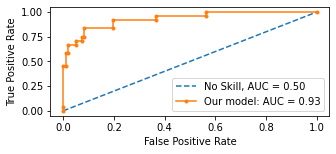

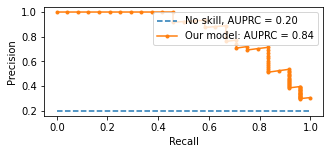

In [24]:
print_metrics(y.flatten(), np.array(prediction_probablity).flatten())

In [23]:
from sklearn.metrics import roc_curve, confusion_matrix , auc, precision_recall_curve, average_precision_score
from sklearn import metrics

def print_metrics(y_true, y_pred):
    import matplotlib.pyplot as plt
    
    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)
    auprc = average_precision_score(y_true, y_pred)
    print('AUC: ',roc_auc, "AUPRC: ", auprc)


    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))


    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > thresholds[ix]).ravel()
    print('TN: ', tn, ", FP: ",fp, ", FN:", fn, ", TP:", tp)
    print("==> Sensitivity (Recall, TPR): %.3f"%(tp/(tp+fn)))
    print("==> Specifity: %.3f"%(tn/(tn+fp)))
    print("==> Positive Predictive Value (PPV) (Precision): %.3f"%(tp / (tp + fp)))
    print("==> Negative Predictive Value (NPV): %.3f"%(tn / (tn + fn)))
    print("==> Accuracy: %.3f"%((tp+tn)/(tn+ fp+ fn+tp)))
    print("==> F1 score: %.3f"%((2*tp)/(2*tp + fp + fn)))
    
    # method I: plt
#     fpr, tpr, _ = roc_curve(y_true, y_pred)
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    ns_probs = [0 for _ in range(len(y_true))]
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill, AUC = %0.2f' % 0.5)
    plt.plot(lr_fpr, lr_tpr, marker='.', label = 'Our model: AUC = %0.2f' % roc_auc)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    lr_precision, lr_recall, _ = precision_recall_curve(y_true, y_pred)
    lr_auc = auc(lr_recall, lr_precision)
    # summarize scores
#     print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    y_true = np.array(y_true)
    no_skill = len(y_true[y_true==1]) / len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill, AUPRC = %0.2f' % no_skill)
    plt.plot(lr_recall, lr_precision, marker='.',label = 'Our model: AUPRC = %0.2f' % auprc)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend(loc = 'upper right')
    # show the plot
    plt.show()

In [37]:
evaluate(np.array([1]*1421+[0]*(10882-1421)), np.random.random((10882,)))

AUC-Macro: 0.4999098116115189, 
 AUC-Micro: 0.4999098116115189, 
 AUPRC: 0.13185149133202492, 
 F1-Binary: 0.0014054813773717496, 
 F1-Macro: 0.46577328785942473, 
 F1-Micro: 0.8694173865098329


In [38]:
evaluate(y.flatten(), np.array(prediction_probablity).flatten())

AUC-Macro: 0.8910590277777778, 
 AUC-Micro: 0.8910590277777778, 
 AUPRC: 0.7615093633633192, 
 F1-Binary: 0.7000000000000001, 
 F1-Macro: 0.8200000000000001, 
 F1-Micro: 0.9
